## FOMC Production
Purpose: Built the code for operational use

In [4]:
import pandas as pd
import pickle
import numpy as np
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder

### 1. Read data from DB
1. Load TFIDF Vectorizer & Pre-Trained Model
2. Load Statement, Minutes & News

In [ ]:
file = open("../../data/db/pickle/model/211028_finalized_model_tuned.pickle", "rb")
stacked_model_svm = pickle.load(file)

file = open('../../data/db/pickle/model/211028_tfidf_vect_tuned.pickle', "rb")
tfidf_vect = pickle.load(file)

file = open("../../data/db/pickle/test/st_df_neutral_filtered.pickle", "rb")
st_df = pickle.load(file)

file = open('../../data/db/pickle/test/mins_df_neutral_filtered.pickle', "rb")
mins_df = pickle.load(file)

file = open('../../data/db/pickle/test/news_df_neutral_filtered.pickle', "rb")
news_df = pickle.load(file)

### 2. Predict Our Historical Dataset

### Machine Learning Model on FOMC Documents

In [ ]:
# FOR MACHINE LEARNING METHOD - distribution of hawkish and dovish

# Statements: initialising with default values
st_df['Score'] = 0
mins_df['Score'] = 0

for index, row in st_df.iterrows():
  
    # some rows are zero
    if len(row['lemmatizedSentences']) == 0:
        continue
    
    df = pd.DataFrame(row['lemmatizedSentences'], columns=['Corpus'])

    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1

    df = df[['Date', 'Corpus', 'Class']]

    # remove rows with null values
    df['Corpus'].replace('', np.nan, inplace=True)
    df.dropna(subset=['Corpus'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # preprocess data
    # -1 -> 0 (DOVISH)
    # 1 -> 1 (HAWKISH)
    # Encode Class
    le = LabelEncoder()
    df['Class_Label'] = le.fit_transform(df['Class'])
    
    # Vectorise Corpus
    X_final_dtm = tfidf_vect.transform(df.Corpus)

    # Model Prediction
    result = stacked_model_svm.predict(X_final_dtm)
    df['Predict'] = result

    # manipulate the data then aggregate the value back into the original dataframe
    NHawkishLabels = len(df[(df['Predict'] == 1)])
    NDovishLabels = len(df[(df['Predict'] == 0)])
    Score = (NHawkishLabels * 1 + NDovishLabels * -1)/(NHawkishLabels + NDovishLabels)
    st_df.loc[index, 'Score'] = Score

for index, row in mins_df.iterrows():
    
    if len(row['lemmatizedSentences']) == 0:
        continue  
    
    df = pd.DataFrame(row['lemmatizedSentences'], columns=['Corpus'])

    df['Date'] = row['date'].strftime("%Y-%m-%d")
    df['Class'] = 0 # Hawkish = +1, Dovish=-1

    df = df[['Date', 'Corpus', 'Class']]

    # remove rows with null values
    df['Corpus'].replace('', np.nan, inplace=True)
    df.dropna(subset=['Corpus'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # preprocess data
    # -1 -> 0 (DOVISH)
    # 1 -> 1 (HAWKISH)
    # Encode Class
    le = LabelEncoder()
    df['Class_Label'] = le.fit_transform(df['Class'])

    # Vectorise Corpus
    X_final_dtm = tfidf_vect.transform(df.Corpus)

    # Model Prediction
    result = stacked_model_svm.predict(X_final_dtm)
    df['Predict'] = result

    # manipulate the data then aggregate the value back into the original dataframe
    NHawkishLabels = len(df[(df['Predict'] == 1)])
    NDovishLabels = len(df[(df['Predict'] == 0)])
    Score = (NHawkishLabels * 1 + NDovishLabels * -1)/(NHawkishLabels + NDovishLabels)
    mins_df.loc[index, 'Score'] = Score

### Filter Keywords & Remove Neutral Sentences for News
Filter sentences with keywords that affects central banks decision (Take 2 hours 40 mins to run)<br>
Transfer Learning for NLP: FINBERT for Text Classification<br>
Filter out Neutral Sentences from FINBERT Model<br>
Reference: https://github.com/yya518/FinBERT

In [ ]:
# ### Filter sentences with keywords that affects central banks decision

# import itertools
# from transformers import BertTokenizer, BertForSequenceClassification
# import numpy as np

# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# # Economic Growth
# economic_growth = ['economic', 'economy', 'growth', 'slowdown', 'outlook']

# # Employment Growth
# employment_growth = ['labor', 'labour', 'unemployment', 'employment', 'job', 'staff', 'wage', 'employ']

# # Inflation
# inflation = ['price', 'prices', 'inflation', 'stagflation', 'disinflation', 'spending', 'spendings', 'cost', 'inflationary']

# # # Policy Rate
# # policy = ['fund', 'funds', 'rate', 'rates', 'risk', 'forecast']

# # Combined Filter words
# filter_words = list(itertools.chain(economic_growth, employment_growth, inflation))


# # FOR MACHINE LEARNING CLASSIFICATION
# def filter_relevant(sentence): # take in list sentence as input

#     if any(s in sentence.lower() for s in filter_words):
    
#         # filter neutral sentiment
#         inputs = tokenizer([sentence], return_tensors="pt", padding=True)
#         outputs = finbert(**inputs)[0]
        
#         if np.argmax(outputs.detach().numpy()[0]) != 0: # not neutral
            
#             return sentence

#         else:
            
#             return ""
  
#     else: # filter out
        
#         return ""

# news_df['Corpus'] = news_df['Corpus'].apply(lambda x: filter_relevant(x))
# news_df = news_df[news_df.Corpus != ""]
# news_df

Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

### Machine Learning Model on News Article

In [84]:
# Calculate the prediction

def aggregate_df(df):
    # Vectorise Corpus
    X_final_dtm = tfidf_vect.transform(df.Corpus)

    # Model Prediction
    result = stacked_model_svm.predict(X_final_dtm)
    df['Score'] = result
    df['Score'] = df['Score'].replace({0: -1})
    df.set_index('Date', inplace=True, drop=True)
    df = df.groupby(level="Date").mean()
    df.drop('Class', axis=1, inplace=True)
    return df

# Calculate prediction score
news_df = aggregate_df(news_df)

# Resample to Month End
news_df.index = pd.to_datetime(news_df.index)
news_df = news_df['Score'].resample('M').mean().to_frame()
news_df

,Score
Date,
1999-11-30,-0.190940
1999-12-31,-0.254120
2000-01-31,-0.131718
2000-02-29,-0.117558
2000-03-31,-0.281578
...,...
2021-06-30,-0.126498
2021-07-31,-0.208678
2021-08-31,-0.144684


In [ ]:
st_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB,Score
0,2000-02-02,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open market...,[committee remains concerned time increases de...,[immediate release federal open market committ...,[committee remains concerned time increase dem...,[immediate release federal open market committ...,1.000000
1,2000-03-21,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open market...,[economic conditions considerations addressed ...,[immediate release federal open market committ...,[committee remains concerned increase demand c...,[immediate release federal open market committ...,1.000000
2,2000-05-16,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open market...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...,[committee concerned disparity growth demand p...,[immediate release federal open market committ...,1.000000
3,2000-06-28,for immediate release the federal open...,Alan Greenspan,For immediate release The Federal Open...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open market...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...,[recent data suggest expansion aggregate deman...,[immediate release federal open market committ...,1.000000
4,2000-08-22,for immediate release \tthe federal op...,Alan Greenspan,For immediate release \tThe Federal Op...,immediate release federal open market committe...,[immediate release federal open market committ...,[for immediate release the federal open market...,[recent data indicated expansion aggregate dem...,[immediate release federal open market committ...,[recent data indicate expansion aggregate dema...,[immediate release federal open market committ...,0.478261
...,...,...,...,...,...,...,...,...,...,...,...,...
183,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...,-0.714286
184,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve central bank united state pro...,-0.428571
185,2021-06-16,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[federal reserve committed using full range to...,[federal reserve central bank united states pr...,[federal reserve commit use full range tool su...,[federal reserve 

In [ ]:
mins_df

,date,contents,speaker,text,contentClean,sentences,original,filterSentences,filterSentencesDB,lemmatizedSentences,lemmatizedSentencesDB,Score
0,2000-02-02,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[buy sells government securities including sec...,[meeting federal open market committee held of...,[information review meeting suggest economic a...,[meeting federal open market committee held of...,0.647059
1,2000-03-21,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[pending completion study committee considerat...,[meeting federal open market committee held of...,[information review meeting suggest expansion ...,[meeting federal open market committee held of...,0.640000
2,2000-05-16,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[committee turned discussion economic financia...,[meeting federal open market committee held of...,[information review meeting suggest economic g...,[meeting federal open market committee held of...,0.551724
3,2000-06-28,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[information review meeting suggest economic e...,[meeting federal open market committee held of...,0.269231
4,2000-08-22,a meeting of the federal open market committe...,Alan Greenspan,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,[meeting federal open market committee held of...,[meeting of the federal open market committee ...,[committee turned discussion economic outlook ...,[meeting federal open market committee held of...,[information review meeting suggest economic a...,[meeting federal open market committee held of...,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...
174,2021-01-27,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark carlson senior economic project manager ...,[federal reserve central bank united states pr...,[clarity facilitates well inform decisionmakin...,[federal reserve central bank united state pro...,-0.051546
175,2021-03-17,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark carlson senior economic project manager ...,[federal reserve central bank united states pr...,[market participant highlight improve economic...,[federal reserve central bank united state pro...,0.054945
176,2021-04-28,"the federal reserve, the central bank of the ...",Jerome Powell,"The Federal Reserve, the central bank of the U...","federal reserve, central bank united states, p...","[federal reserve, central bank united states, ...","[the federal reserve, the central bank of the ...",[mark carlson senior economic project manager ...,[federal reserve central bank united states

### 3. Scale the HD Index Distribution

In [ ]:
def scale(df):
    
    # Get Hawkish and Dovish Max
    max_hawk = df.Score.max()
    min_dov = df.Score.min()

    # Calculate the Ratio Level
    df['Scaled Score'] = df['Score'].apply(lambda x: x/max_hawk if x>0 else -(x/min_dov))
    return df

In [ ]:
st_df = scale(st_df)
mins_df = scale(mins_df)

In [ ]:
# FOR PLOTTING
st_df.set_index('date', inplace=True, drop=True)
mins_df.set_index('date', inplace=True, drop=True)

### 4. Plot for HD Index

### Net Sentiments (Statements)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# check the score plot
doc_type = "FOMC Statements"
font_size_title =  16 #@param {type:"raw"}
font_size_subtitle =  12.5 #@param {type:"raw"}
font_size_legend =   11 #@param {type:"raw"}
font_size_notes = 9 #@param {type:"raw"}
graph_dir = ''
title_loc = 'left'

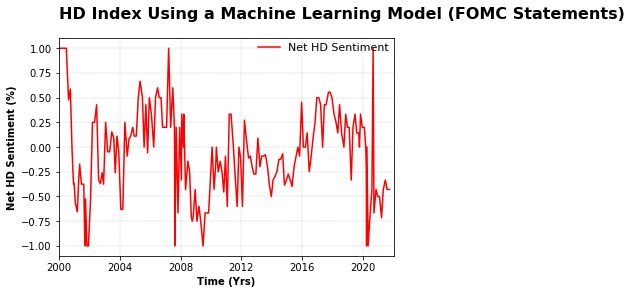

In [ ]:
# HD-Index for statements

NetSentiment = st_df['Scaled Score']

# Initialize figure container
fig, ax = plt.subplots()

# Supertitle
plt.suptitle('HD Index Using a Machine Learning Model ' + '({})'.format(doc_type), horizontalalignment = 'left', x = fig.subplotpars.left, y = 0.99, fontsize = font_size_title, fontweight = "bold")

# Main plots
ax.plot(st_df.index, NetSentiment, c = 'red', label = 'Net HD Sentiment')
ax.legend(prop = {'size': font_size_legend}, loc="best", borderaxespad=0, frameon=0)
ax.set_ylabel('Net HD Sentiment (%)', fontweight = "bold")
ax.set_xlabel('Time (Yrs)', fontweight = "bold")

# Formatting
datemin = np.datetime64(st_df.index[0], 'Y')
datemax = np.datetime64(st_df.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = ax.get_legend_handles_labels()

# Grid
ax.grid(color = 'black', alpha = 0.5, linestyle = '-.', linewidth=0.2)

# Finalize
handles, labels = ax.get_legend_handles_labels()

# Show inline
plt.show()

### Net Sentiments (Minutes)

In [ ]:
doc_type = "FOMC Minutes"
font_size_title =  16 #@param {type:"raw"}
font_size_subtitle =  12.5 #@param {type:"raw"}
font_size_legend =   11 #@param {type:"raw"}
font_size_notes = 9 #@param {type:"raw"}
graph_dir = ''
title_loc = 'left'

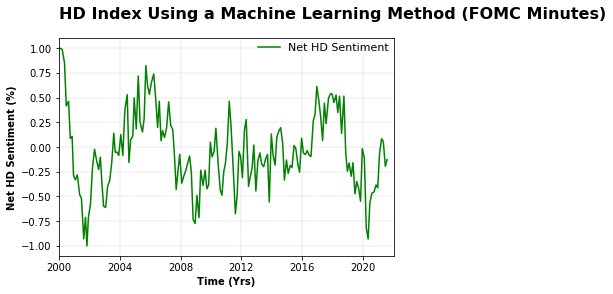

In [ ]:
# HD-Index for Minutes

NetSentiment = mins_df['Scaled Score']

# Initialize figure container
fig, ax = plt.subplots()

# Supertitle
plt.suptitle('HD Index Using a Machine Learning Method ' + '({})'.format(doc_type), horizontalalignment = 'left', x = fig.subplotpars.left, y = 0.99, fontsize = font_size_title, fontweight = "bold")

# Main plots
ax.plot(mins_df.index, NetSentiment, c = 'green', label = 'Net HD Sentiment')
ax.legend(prop = {'size': font_size_legend}, loc="best", borderaxespad=0, frameon=0)
ax.set_ylabel('Net HD Sentiment (%)', fontweight = "bold")
ax.set_xlabel('Time (Yrs)', fontweight = "bold")

# Formatting
datemin = np.datetime64(mins_df.index[0], 'Y')
datemax = np.datetime64(mins_df.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = ax.get_legend_handles_labels()

# Grid
ax.grid(color = 'black', alpha = 0.5, linestyle = '-.', linewidth=0.2)

# Finalize
handles, labels = ax.get_legend_handles_labels()

# Show inline
plt.show()

# Save Graphics
fig.savefig(graph_dir + 'sentiment_bow_' + doc_type + '.png')

### Net Sentiments (News)

In [85]:
doc_type = "News Article"
font_size_title =  16 #@param {type:"raw"}
font_size_subtitle =  12.5 #@param {type:"raw"}
font_size_legend =   11 #@param {type:"raw"}
font_size_notes = 9 #@param {type:"raw"}
graph_dir = ''
title_loc = 'left'

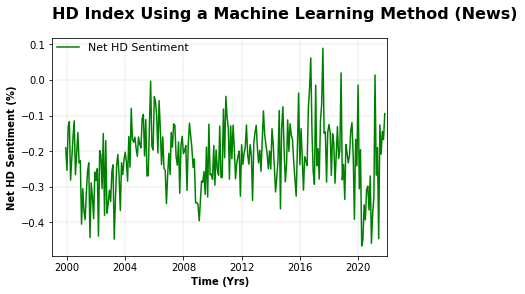

In [86]:
# HD-Index for Minutes

NetSentiment = news_df['Score']

# Initialize figure container
fig, ax = plt.subplots()

# Supertitle
plt.suptitle('HD Index Using a Machine Learning Method ' + '({})'.format(doc_type), horizontalalignment = 'left', x = fig.subplotpars.left, y = 0.99, fontsize = font_size_title, fontweight = "bold")

# Main plots
ax.plot(news_df.index, NetSentiment, c = 'green', label = 'Net HD Sentiment')
ax.legend(prop = {'size': font_size_legend}, loc="best", borderaxespad=0, frameon=0)
ax.set_ylabel('Net HD Sentiment (%)', fontweight = "bold")
ax.set_xlabel('Time (Yrs)', fontweight = "bold")

# Formatting
datemin = np.datetime64(news_df.index[0], 'Y')
datemax = np.datetime64(news_df.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = ax.get_legend_handles_labels()

# Grid
ax.grid(color = 'black', alpha = 0.5, linestyle = '-.', linewidth=0.2)

# Finalize
handles, labels = ax.get_legend_handles_labels()

# Show inline
plt.show()

In [81]:
import plotly.express as px

fig = px.line(news_df, x=news_df.index, y="Score", title='HD Index (News)')
fig.show()

### 5. Save the df into a pickle
For future scoring reference

In [ ]:
# # save model to pickle
# import pickle

# # save the model to disk
# filename = '/content/drive/My Drive/Capstone Y4S1/Code/pickle/211022_1800_st_df_finalized_result.pickle'
# dbfile =  open(filename, 'wb')
# pickle.dump(st_df, dbfile)
# dbfile.close()

# # save the model to disk
# filename = '/content/drive/My Drive/Capstone Y4S1/Code/pickle/211022_1800_mins_df_finalized_result.pickle'
# dbfile =  open(filename, 'wb')
# pickle.dump(mins_df, dbfile)
# dbfile.close()